In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obspy
import sys
import os
from scipy import stats,signal
import librosa
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
# import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Getting Data

In [37]:
os.chdir('data')
orca_df = pd.read_csv("orca_data.csv")
noise_df = pd.read_csv("noise_data.csv")

In [38]:
orca_df = orca_df.sample(n=len(orca_df)//20) # shape = (97, 3)
noise_df = noise_df.sample(n=len(noise_df)//3) # shape = (107, 3)

# Data Preparation

In [47]:
os.makedirs('orca_spectrogram')
os.makedirs('noise_spectrogram')

# Add column with labels to orca_df and noise_df, then merge the two together
orca_df['label'] = 1
noise_df['label'] = 0
data_df = pd.concat([orca_df, noise_df], ignore_index=True)
num_total_data = len(data_df) # 1 data = 1 row in df

,wav_filename,start_time_s,end_time_s,label
0,9750100B.wav,0.000000,1.000000,1
1,97770004.wav,0.000000,1.000000,1
2,1562337136_0010.wav,47.755859,48.755859,1
3,9750300Z.wav,0.000000,1.000000,1
4,97500008.wav,0.000000,1.000000,1
...,...,...,...,...
199,790150007.wav,22.050000,23.050000,0
200,780210003.wav,0.000000,1.000000,0
201,1562340736_0009.wav,2.322484,3.322484,0
202,1562340736_0007.wav,0.000000,1.000000,0


In [40]:
dir_path = '/home/ajm76/OrcaSeis/data'

for index, row in data_df.iterrows():
    filename = row['wav_filename']
    filepath = 'wav/' + filename
    start_time = row['start_time_s']  # Keep in seconds
    end_time = row['end_time_s']  # Keep in seconds

    # Load the original wav file
    y, sr = librosa.load(filepath) #sr = 22050 for all

    # Convert start and end times to sample indices
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Extract the chunk
    chunk = y[start_sample:end_sample]

    # Generate a Short-Time Fourier Transform (STFT) spectrogram
    D = librosa.stft(chunk)

    # Convert amplitude spectrogram to dB-scaled spectrogram
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Save the spectrogram as a NumPy array
    dir_name = ''
    if row['label'] == 1:
        dir_name = 'orca_spectrogram'
    else:
        dir_name = 'noise_spectrogram'
    np.save(os.path.join(dir_path, dir_name, str(index) + '.npy'), S_db)    

In [41]:
start=-50
input_window_length=100 # in seconds
fs=5000 # target sampling rate

number_data_per_class=2000 # number of data samples per class
num_channels=3  # number of components to check

SNR_THR = 0

all_data=False
shifting=True
augmentation=False


# training parameters
train_split = 70
val_split=20
test_split = 10
learning_rate=0.001
batch_size=24
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()

# Defining Model

In [42]:
class OrcaCNN(nn.Module):
    def __init__(self, num_classes=4, num_channels = 3,dropout_rate=0.2):
        super(OrcaCNN, self).__init__()
        # Define the layers of the CNN architecture
        self.conv1 = nn.Conv1d(in_channels= num_channels, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(79808, 128)  # Adjust input size based on your data
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self.dropout = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(32)#, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(64)#, dtype=torch.float64)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(num_classes)

    def forward(self, x):

        # x = self.pool1(F.relu(self.bn2(self.conv2(x)))) # feature extraction, output size of 8,1250 
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2_bn(self.fc2(x))
        # do not apply softmax here, as it will be applied in the loss function
        return x


# Testing CNN model

In [43]:
# Assuming the input shape is (batch_size, num_channels, num_features)
# batch_size = 64  # You can adjust the batch size as needed
num_channels = 3
num_features = 5000
# Create a random input tensor with the specified shape
random_input = torch.randn(batch_size, num_channels,int(input_window_length*fs)).to(device)
# Initialize your model
model = OrcaCNN(num_classes=4, num_channels=num_channels).to(device)  # Use 'cuda' if you have a GPU available
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters in OrcaCNN in log10: {np.log10(total_params)}")

Total number of parameters in OrcaCNN in log10: 7.009762693972353


In [44]:
from torch.utils.data import Dataset
class PNWDataSet(Dataset): # create custom dataset
    def __init__(self, data,labels,num_classes): # initialize
        self.data = data 
        self.labels = labels
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_labels = self.labels[index]        
        return torch.Tensor(sample_data), sample_labels.float()  # return data as a tensor

In [32]:
# Loading first sepctrogram 
spectrogram_1 = np.load(os.path.join(dir_path, "orca_spectrogram", "1.npy"))

In [51]:
N = spectrogram_1.shape[0]
data = np.zeros(shape=(num_total_data, N, spectrogram_1.shape[1]))
labels = np.zeros(num_total_data)
print(spectrogram_1.shape)

# Shuffling the data
random.seed(1234)
data_df = data_df.sample(frac=1).reset_index(drop=True)

# Populating data and labels arrays
for index, row in data_df.iterrows():
    file_name = str(index) + ".npy"
    
    # Load the spectrogram
    cat_path = ""
    if row['label'] == 0:
        cat_path = 'noise_spectrogram'
    else:
        cat_path = 'orca_spectrogram'
    spectrogram = np.load(os.path.join(dir_path, cat_path, file_name))
    
    # Select window of data (first 100 points)
    spectrogram = spectrogram[:N, :]
    
    # Normalize using std deviation
    mean = np.mean(spectrogram)
    std_dev = np.std(spectrogram)
    normalized_spectrogram = (spectrogram - mean) / std_dev
    
    # Add spectrogram to data array
    data[index] = normalized_spectrogram
    
    # Populate labels array
    labels[index] = row['label'] 
    
    # TESTING CODE
#     if index == 2:
#         break
    

# Remove rows of 0s if there are any and return data and labels arrays
idx = np.where(np.mean(np.abs(data[:,2,0:10]),axis=-1)>0)[0]
data_df.head()

(1025, 44)


ValueError: could not broadcast input array from shape (1025,1357) into shape (1025,44)

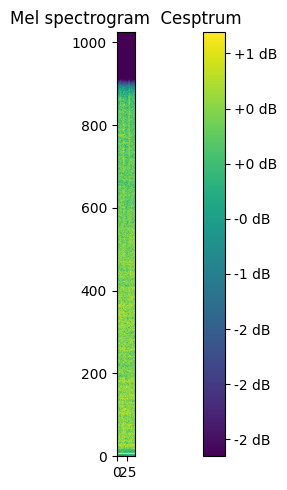

In [52]:
plt.figure(figsize=(14, 5))
plt.imshow(data[2], origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram  Cesptrum')
plt.tight_layout()
plt.show()